In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0
Receiving objects: 100% (53/53), 32.99 KiB | 11.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.


/tmp/ipykernel_38124/3252482141.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


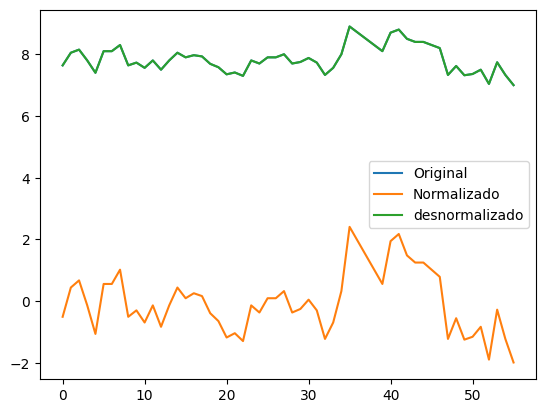

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler(output):
    out = df_orig[output].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y1")
test_out_scaler(output="y1")

In [3]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-25 01:14:55.861897: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 01:14:55.928616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 01:14:55.928665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 01:14:55.929940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 01:14:55.938069: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 01:14:55.939046: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats as stats
import statsmodels.api as sm

class Rebuild:
    def __init__(self):
        self.df = pd.read_excel(f"../../better_results.xlsx")        

    def LoadModelWeights(self, model, fileName):        
        path = f"../models/{fileName}.keras"
        model.load_weights(path)

    def LoadPrevDataset(self, fileName):
        fileName = fileName.replace("model", "dataset")
        pos = fileName.rfind("_")
        path = f"../dataset/{fileName[:pos]}.pkl" 
        with open(path, 'rb') as f:
            _data, _train, _vt, _val, _test = pickle.load(f)
        self._data, self._train, self._vt, self._val, self._test = _data, _train, _vt, _val, _test    
    
    def setArchitecture(self, _hidden_sizes, _pg, _lr):
        shuffler = ShuffleArchitecture(input_size  = 5,
                                        hidden_sizes = _hidden_sizes,
                                        output_size = 1,
                                        act_h = 'tanh',
                                        act_o = 'linear',
                                        param_reg=_pg)
        shuffler.set_architecture()
        return(shuffler.create_model(_lr))            

    def getArchitecture(self, architecture):
        hidden_size = [int(x) for x in architecture.split("[")[1].split("]")[0].split(", ")]
        regularizer = float(architecture.split("regularizer=")[1].split(",")[0])
        learning_rate = float(architecture.split("learning_rate=")[1])
        return hidden_size, regularizer, learning_rate

    def predictResults(self):
        pred = self.lm_model.predict(self._data[0]).flatten()
        test_pred = self.lm_model.predict(self._test[0]).flatten()
        val_pred = self.lm_model.predict(self._val[0]).flatten()
        vt_pred = self.lm_model.predict(self._vt[0]).flatten()

        # Calculando as metricas com a saida desnormalizada
        pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
        test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
        val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
        vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

        out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
        test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
        val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
        vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))
        
        original_values = [out_denorm, test_denorm, val_denorm, vt_denorm]
        predicted_values = [pred_denorm, test_pred_denorm, val_pred_denorm, vt_pred_denorm]
        return (original_values, predicted_values)

    def AddWaste(self, model, original_values, predicted_values):
        waste = original_values.flatten() - predicted_values.flatten()
        return (waste.mean())

    def DisplayQqplot(self, model_name, original_values, predicted_values):
        waste = original_values.flatten() - predicted_values.flatten()
        sm.qqplot(waste, line='s')
        plt.title(f'QQ Plot - {model_name}')
        plt.show()

    def QQPlot(self):
        results = []
        for file_model, architecture in zip(self.df["model"], self.df["Architecture"]):
            hidden_size, regularizer, learning_rate = self.getArchitecture(architecture)
            self.lm_model = self.setArchitecture(hidden_size, regularizer, learning_rate)
            self.LoadModelWeights(self.lm_model, file_model)
            self.LoadPrevDataset(file_model)
            original_values, predicted_values = self.predictResults()
            waste_mean = self.AddWaste(file_model, original_values[0], predicted_values[0])
            if round(waste_mean, 3) == 0.000:
                self.DisplayQqplot(file_model, original_values[0], predicted_values[0])
                row_data = self.df.loc[self.df['model'] == file_model].iloc[0].to_dict()
                row_data['waste_mean'] = waste_mean
                results.append(row_data)
        if (results):
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values(by='waste_mean', key=lambda x: abs(x - 0))
            results_df.to_excel("../../waste_results.xlsx", index=False)



1/1 [==============================] - 0s 16ms/step


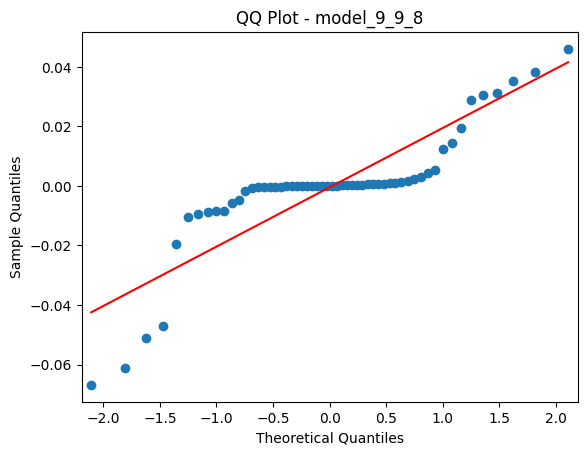

1/1 [==============================] - 0s 13ms/step


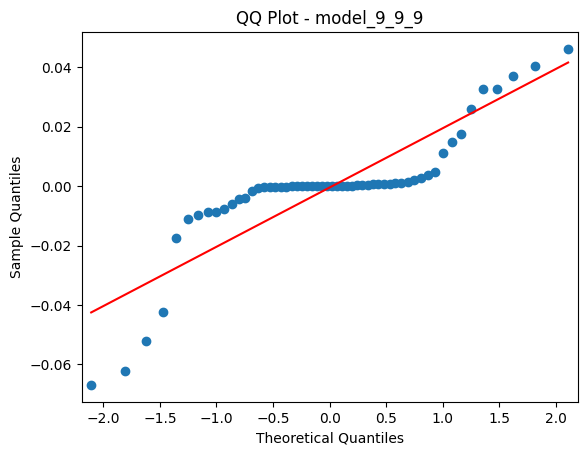

1/1 [==============================] - 0s 14ms/step


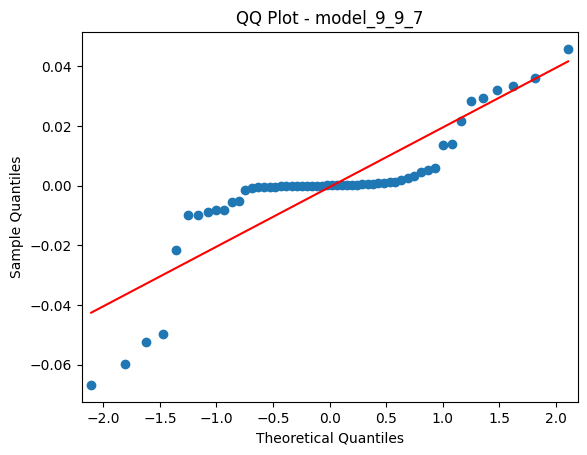

1/1 [==============================] - 0s 14ms/step


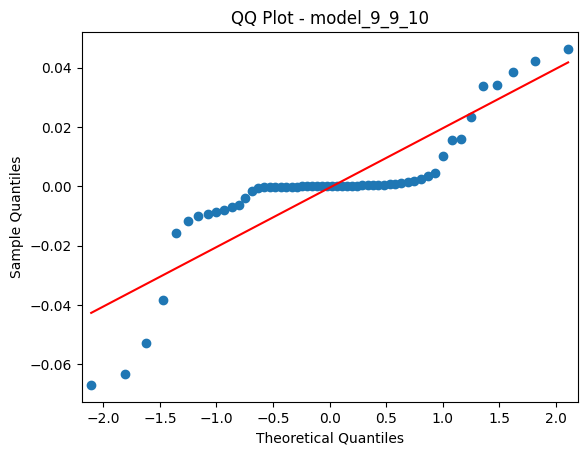

1/1 [==============================] - 0s 16ms/step


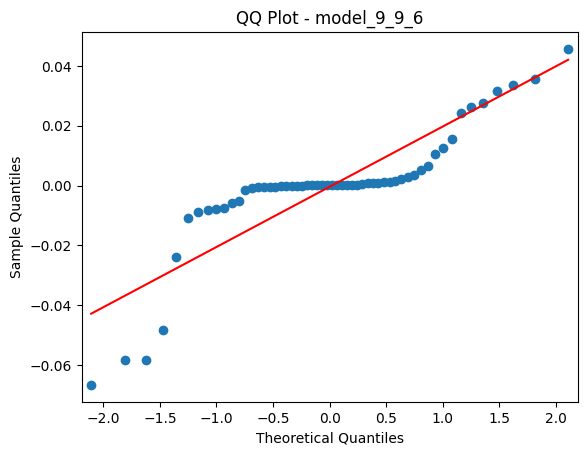

1/1 [==============================] - 0s 14ms/step


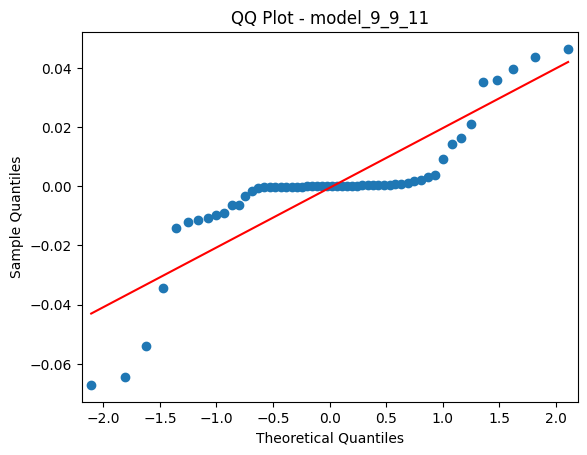

1/1 [==============================] - 0s 14ms/step


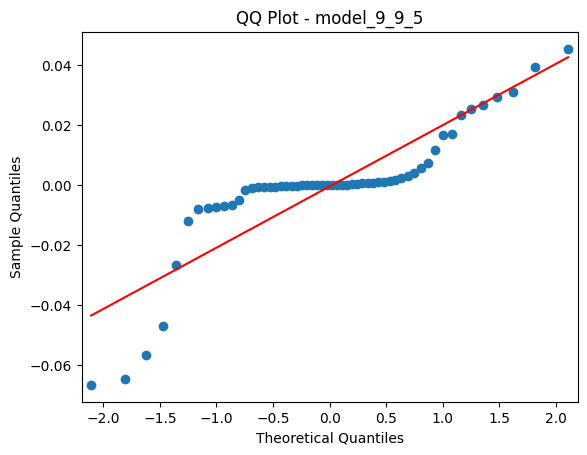

1/1 [==============================] - 0s 14ms/step


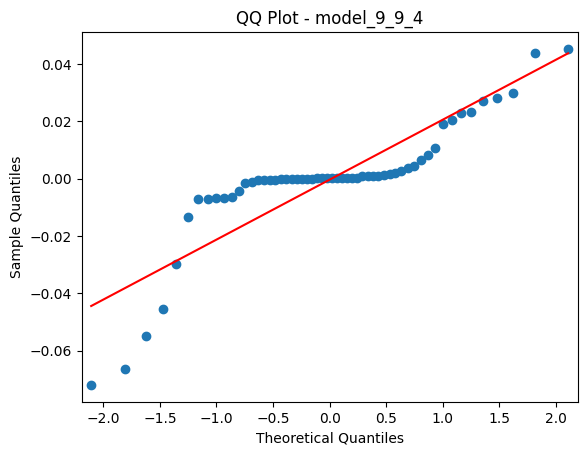

1/1 [==============================] - 0s 14ms/step


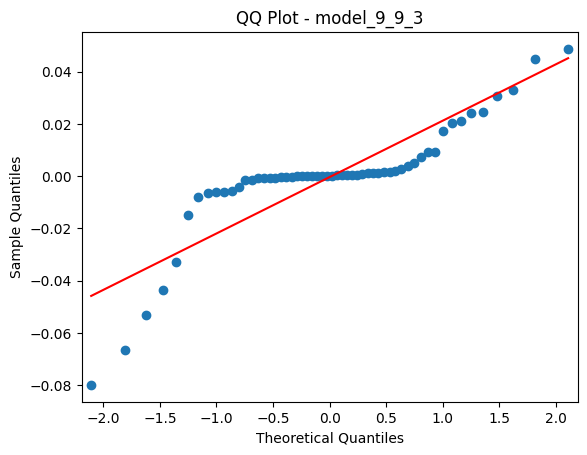

1/1 [==============================] - 0s 13ms/step


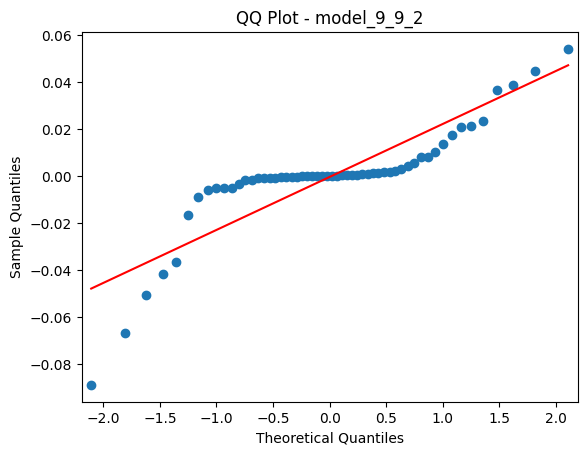

1/1 [==============================] - 0s 16ms/step


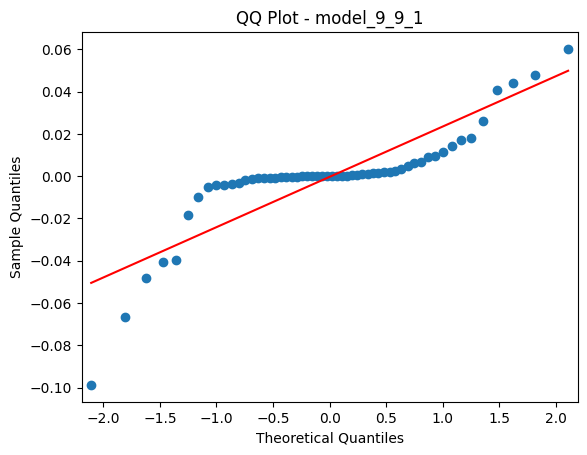

1/1 [==============================] - 0s 14ms/step


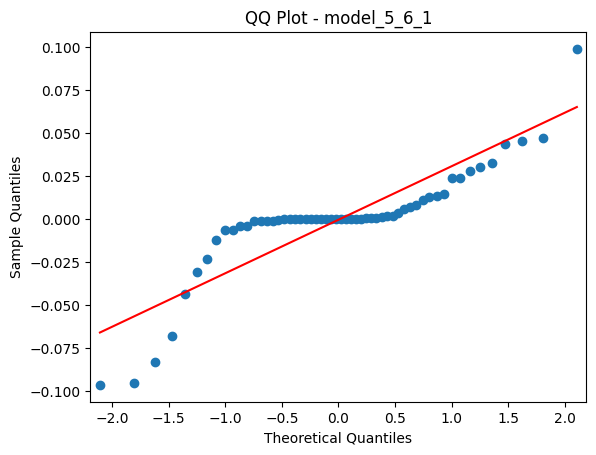

1/1 [==============================] - 0s 13ms/step


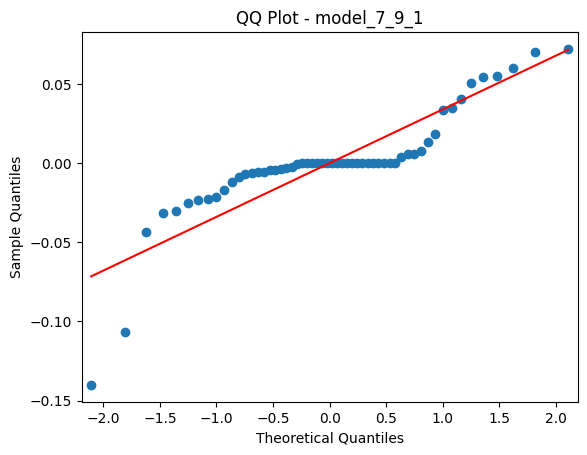

1/1 [==============================] - 0s 19ms/step


In [5]:
Rebuilder = Rebuild()
Rebuilder.QQPlot()